In [ ]:
!sudo rm -rf /content/sample_data

In [ ]:
!curl -L -o /content/archive.zip https://www.kaggle.com/api/v1/datasets/download/rupakroy/urban-sound-8k
!unzip /content/archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-10.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-11.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-12.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-13.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-14.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-15.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-16.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-17.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-18.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-19.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-2.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0

In [ ]:
!sudo rm -rf /content/archive.zip
!sudo rm -rf /content/UrbanSound8K.csv
!sudo rm -rf /content/UrbanSound8K_README.txt

In [ ]:
import pandas as pd

# Load the metadata CSV
csv_file_path = '/content/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv'  # Replace with the path to UrbanSound8K.csv
metadata = pd.read_csv(csv_file_path)

# Find unique class names and their corresponding numbers
unique_classes = metadata[['classID', 'class']].drop_duplicates().sort_values(by='classID').reset_index(drop=True)

# Display the unique classes and their IDs
print("Unique classes and their corresponding class IDs:")
print(unique_classes)


Unique classes and their corresponding class IDs:
   classID             class
0        0   air_conditioner
1        1          car_horn
2        2  children_playing
3        3          dog_bark
4        4          drilling
5        5     engine_idling
6        6          gun_shot
7        7        jackhammer
8        8             siren
9        9      street_music


In [ ]:
classes_to_keep = [0,1,2,3,4,6,8,9]

In [ ]:
import pandas as pd
import numpy as np
import librosa
import os

def load_filtered_metadata(csv_file_path, classes_to_keep):
    # Load the metadata CSV file
    metadata = pd.read_csv(csv_file_path)
    # Filter the metadata to keep only the specified classes
    filtered_metadata = metadata[metadata['classID'].isin(classes_to_keep)]
    return filtered_metadata


In [ ]:
!pip install librosa

In [ ]:
def convert_to_mfcc_with_filtered_labels(audio_dir, metadata, max_pad_len=200):
    # Initialize dataset list
    dataset = []

    for index, row in metadata.iterrows():
        # Build file path
        file_name = row['slice_file_name']
        fold = row['fold']
        label = row['classID']
        file_path = os.path.join(audio_dir, f'fold{fold}', file_name)

        # Load the audio file
        try:
            audio, sr = librosa.load(file_path)

            # Convert to MFCC
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

            # Pad or truncate MFCCs to ensure uniform shape
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            # Append (features, label) as a tuple to the dataset list
            dataset.append((mfccs, label))

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue

    # Convert dataset list to a NumPy array
    return np.array(dataset, dtype=object)


# Paths
audio_dir = '/content/UrbanSound8K/UrbanSound8K/audio'  # Replace with the path to the UrbanSound8K audio directory

# Load filtered metadata and create the dataset
filtered_metadata = load_filtered_metadata(csv_file_path, classes_to_keep)
dataset = convert_to_mfcc_with_filtered_labels(audio_dir, filtered_metadata)

# Check dataset shape and structure
print("Filtered dataset shape:", dataset.shape)
print("First element (MFCCs, Label):", dataset[0])


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Filtered dataset shape: (6732, 2)
First element (MFCCs, Label): [array([[-332.0388   , -169.58775  ,  -90.246826 , ...,    0.       ,
            0.       ,    0.       ],
        [ 119.39658  ,   83.29506  ,   61.68872  , ...,    0.       ,
            0.       ,    0.       ],
        [-102.87578  , -120.09383  , -129.49957  , ...,    0.       ,
            0.       ,    0.       ],
        ...,
        [  12.779535 ,    3.5483198,   -6.067363 , ...,    0.       ,
            0.       ,    0.       ],
        [  -3.7113366,  -11.908623 ,   -5.7381015, ...,    0.       ,
            0.       ,    0.       ],
        [ -21.403109 ,  -27.239983 ,  -21.73337  , ...,    0.       ,
            0.       ,    0.       ]], dtype=float32)                 3]


In [ ]:
# Convert dataset to separate features and labels arrays
features = np.array([sample[0] for sample in dataset], dtype=np.float32)  # Shape: (6732, n_mfcc, max_pad_len)
labels = np.array([sample[1] for sample in dataset], dtype=int)           # Shape: (6732,)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (6732, 13, 200)
Labels shape: (6732,)


In [ ]:
# Counting unique labels and their occurrences
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the counts of each label
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1000
Label: 1, Count: 429
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 6, Count: 374
Label: 8, Count: 929
Label: 9, Count: 1000


In [ ]:
!curl -L -o /content/gunshot.zip https://www.kaggle.com/api/v1/datasets/download/emrahaydemr/gunshot-audio-dataset
!unzip /content/gunshot.zip -d /content/Gunshot
!sudo rm -rf /content/gunshot.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  380M  100  380M    0     0  41.5M      0  0:00:09  0:00:09 --:--:-- 35.1M
Archive:  /content/gunshot.zip
  inflating: /content/Gunshot/AK-12/3 (1).wav  
  inflating: /content/Gunshot/AK-12/3 (10).wav  
  inflating: /content/Gunshot/AK-12/3 (11).wav  
  inflating: /content/Gunshot/AK-12/3 (12).wav  
  inflating: /content/Gunshot/AK-12/3 (13).wav  
  inflating: /content/Gunshot/AK-12/3 (14).wav  
  inflating: /content/Gunshot/AK-12/3 (15).wav  
  inflating: /content/Gunshot/AK-12/3 (16).wav  
  inflating: /content/Gunshot/AK-12/3 (17).wav  
  inflating: /content/Gunshot/AK-12/3 (18).wav  
  inflating: /content/Gunshot/AK-12/3 (19).wav  
  inflating: /content/Gunshot/AK-12/3 (2).wav  
  inflating: /content/Gunshot/AK-12/3 (20).wav  
  inflating: /cont

In [ ]:
import os
import librosa
import numpy as np

# Path to the main folder containing gunshot subfolders
gunshot_main_folder = '/content/Gunshot'  # Replace with actual path
gunshot_label_id = 6  # Label ID for gunshot as per UrbanSound8K's classID

# Parameters for MFCC extraction
n_mfcc = 13
max_pad_len = 200

# Ensure dataset is a list initially
dataset = dataset.tolist() if isinstance(dataset, np.ndarray) else dataset

# Function to process and add gunshot files from multiple subfolders
def add_combined_gunshots_to_dataset(main_folder, label_id, dataset):
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Skip if it's not a directory
        if not os.path.isdir(subfolder_path):
            continue

        # Process each file in the subfolder
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)

            # Load audio and compute MFCCs
            audio, sr = librosa.load(file_path)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            # Pad or truncate MFCCs to ensure uniform shape
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            # Append the MFCC and label tuple to the dataset list
            dataset.append((mfccs, label_id))

# Call the function to add gunshot data from all subfolders
add_combined_gunshots_to_dataset(gunshot_main_folder, gunshot_label_id, dataset)

# Convert dataset to NumPy array if needed
dataset = np.array(dataset, dtype=object)  # dtype=object due to mixed types (MFCC array and label)

print("Updated dataset shape:", dataset.shape)


Updated dataset shape: (7583, 2)


In [ ]:
# Convert dataset to separate features and labels arrays
features = np.array([sample[0] for sample in dataset], dtype=np.float32)  # Shape: (6732, n_mfcc, max_pad_len)
labels = np.array([sample[1] for sample in dataset], dtype=int)           # Shape: (6732,)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (7583, 13, 200)
Labels shape: (7583,)


In [ ]:
# Counting unique labels and their occurrences
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the counts of each label
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1000
Label: 1, Count: 429
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 6, Count: 1225
Label: 8, Count: 929
Label: 9, Count: 1000


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Define the ratios for train, validation, and test splits
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# First, remove samples with label 1
mask = labels != 1
filtered_features = features[mask]
filtered_labels = labels[mask]

# Split dataset into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    filtered_features,
    filtered_labels,
    test_size=(1 - train_ratio),
    stratify=filtered_labels,
    random_state=42
)

# Then split temp into validation and test
test_size_ratio = test_ratio / (test_ratio + valid_ratio)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=test_size_ratio,
    stratify=y_temp,
    random_state=42
)

# Check the shapes of each set
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Check label distribution in each set
def check_class_distribution(labels, name):
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} Set Class Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Label: {label}, Count: {count}")

check_class_distribution(y_train, "Training")
check_class_distribution(y_valid, "Validation")
check_class_distribution(y_test, "Test")

Training set shape: (5007, 13, 200) (5007,)
Validation set shape: (1073, 13, 200) (1073,)
Test set shape: (1074, 13, 200) (1074,)

Training Set Class Distribution:
Label: 0, Count: 700
Label: 2, Count: 700
Label: 3, Count: 700
Label: 4, Count: 700
Label: 6, Count: 857
Label: 8, Count: 650
Label: 9, Count: 700

Validation Set Class Distribution:
Label: 0, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 150
Label: 6, Count: 184
Label: 8, Count: 139
Label: 9, Count: 150

Test Set Class Distribution:
Label: 0, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 150
Label: 6, Count: 184
Label: 8, Count: 140
Label: 9, Count: 150


In [ ]:
!pip install seaborn tqdm

In [ ]:
# HIDDEN_SIZE = 128    # Try 64, 128, 256
# NUM_LAYERS = 2       # Try 1, 2, 3
# DROPOUT = 0.3        # Try 0.2, 0.3, 0.4
# BATCH_SIZE = 32      # Try 16, 32, 64
# LEARNING_RATE = 0.001  # Try 0.01, 0.001, 0.0001

Using device: cuda

Epoch 1/50


Training: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s, loss=1.0160, acc=63.99%]


Train Loss: 1.0160, Train Acc: 0.6399
Valid Loss: 0.7770, Valid Acc: 0.7195

Epoch 2/50


Training: 100%|██████████| 157/157 [00:03<00:00, 47.37it/s, loss=0.6975, acc=76.45%]


Train Loss: 0.6975, Train Acc: 0.7645
Valid Loss: 0.6056, Valid Acc: 0.7996

Epoch 3/50


Training: 100%|██████████| 157/157 [00:02<00:00, 68.37it/s, loss=0.5703, acc=80.67%]


Train Loss: 0.5703, Train Acc: 0.8067
Valid Loss: 0.6513, Valid Acc: 0.7856

Epoch 4/50


Training: 100%|██████████| 157/157 [00:02<00:00, 68.62it/s, loss=0.4899, acc=83.22%]


Train Loss: 0.4899, Train Acc: 0.8322
Valid Loss: 0.4936, Valid Acc: 0.8276

Epoch 5/50


Training: 100%|██████████| 157/157 [00:02<00:00, 68.33it/s, loss=0.4200, acc=85.58%]


Train Loss: 0.4200, Train Acc: 0.8558
Valid Loss: 0.4940, Valid Acc: 0.8369

Epoch 6/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.44it/s, loss=0.3876, acc=86.34%]


Train Loss: 0.3876, Train Acc: 0.8634
Valid Loss: 0.5971, Valid Acc: 0.8108

Epoch 7/50


Training: 100%|██████████| 157/157 [00:02<00:00, 67.76it/s, loss=0.3599, acc=87.44%]


Train Loss: 0.3599, Train Acc: 0.8744
Valid Loss: 0.5166, Valid Acc: 0.8388

Epoch 8/50


Training: 100%|██████████| 157/157 [00:02<00:00, 67.86it/s, loss=0.3199, acc=89.33%]


Train Loss: 0.3199, Train Acc: 0.8933
Valid Loss: 0.4061, Valid Acc: 0.8658

Epoch 9/50


Training: 100%|██████████| 157/157 [00:02<00:00, 67.76it/s, loss=0.3045, acc=89.53%]


Train Loss: 0.3045, Train Acc: 0.8953
Valid Loss: 0.4278, Valid Acc: 0.8593

Epoch 10/50


Training: 100%|██████████| 157/157 [00:02<00:00, 68.15it/s, loss=0.3083, acc=90.05%]


Train Loss: 0.3083, Train Acc: 0.9005
Valid Loss: 0.4327, Valid Acc: 0.8630

Epoch 11/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.85it/s, loss=0.2806, acc=90.21%]


Train Loss: 0.2806, Train Acc: 0.9021
Valid Loss: 0.4173, Valid Acc: 0.8602

Epoch 12/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.89it/s, loss=0.2562, acc=91.35%]


Train Loss: 0.2562, Train Acc: 0.9135
Valid Loss: 0.4372, Valid Acc: 0.8667

Epoch 13/50


Training: 100%|██████████| 157/157 [00:02<00:00, 67.16it/s, loss=0.2496, acc=91.49%]


Train Loss: 0.2496, Train Acc: 0.9149
Valid Loss: 0.4357, Valid Acc: 0.8714

Epoch 14/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.93it/s, loss=0.2096, acc=92.13%]


Train Loss: 0.2096, Train Acc: 0.9213
Valid Loss: 0.3701, Valid Acc: 0.8826

Epoch 15/50


Training: 100%|██████████| 157/157 [00:02<00:00, 67.24it/s, loss=0.2223, acc=92.49%]


Train Loss: 0.2223, Train Acc: 0.9249
Valid Loss: 0.4871, Valid Acc: 0.8574

Epoch 16/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.29it/s, loss=0.2153, acc=92.65%]


Train Loss: 0.2153, Train Acc: 0.9265
Valid Loss: 0.4238, Valid Acc: 0.8705

Epoch 17/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.68it/s, loss=0.1966, acc=93.17%]


Train Loss: 0.1966, Train Acc: 0.9317
Valid Loss: 0.4318, Valid Acc: 0.8798

Epoch 18/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.98it/s, loss=0.1797, acc=93.85%]


Train Loss: 0.1797, Train Acc: 0.9385
Valid Loss: 0.3868, Valid Acc: 0.8770

Epoch 19/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.32it/s, loss=0.1630, acc=94.37%]


Train Loss: 0.1630, Train Acc: 0.9437
Valid Loss: 0.4435, Valid Acc: 0.8686

Epoch 20/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.96it/s, loss=0.1898, acc=93.21%]


Train Loss: 0.1898, Train Acc: 0.9321
Valid Loss: 0.4513, Valid Acc: 0.8714

Epoch 21/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.84it/s, loss=0.0895, acc=96.88%]


Train Loss: 0.0895, Train Acc: 0.9688
Valid Loss: 0.2729, Valid Acc: 0.9143

Epoch 22/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.32it/s, loss=0.0550, acc=98.30%]


Train Loss: 0.0550, Train Acc: 0.9830
Valid Loss: 0.2788, Valid Acc: 0.9143

Epoch 23/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.55it/s, loss=0.0452, acc=98.52%]


Train Loss: 0.0452, Train Acc: 0.9852
Valid Loss: 0.3103, Valid Acc: 0.9161

Epoch 24/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.25it/s, loss=0.0435, acc=98.64%]


Train Loss: 0.0435, Train Acc: 0.9864
Valid Loss: 0.2994, Valid Acc: 0.9161

Epoch 25/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.26it/s, loss=0.0338, acc=98.96%]


Train Loss: 0.0338, Train Acc: 0.9896
Valid Loss: 0.3148, Valid Acc: 0.9189

Epoch 26/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.05it/s, loss=0.0272, acc=99.20%]


Train Loss: 0.0272, Train Acc: 0.9920
Valid Loss: 0.3332, Valid Acc: 0.9133

Epoch 27/50


Training: 100%|██████████| 157/157 [00:02<00:00, 63.68it/s, loss=0.0250, acc=99.22%]


Train Loss: 0.0250, Train Acc: 0.9922
Valid Loss: 0.3328, Valid Acc: 0.9180

Epoch 28/50


Training: 100%|██████████| 157/157 [00:02<00:00, 66.20it/s, loss=0.0224, acc=99.44%]


Train Loss: 0.0224, Train Acc: 0.9944
Valid Loss: 0.3258, Valid Acc: 0.9208

Epoch 29/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.86it/s, loss=0.0171, acc=99.52%]


Train Loss: 0.0171, Train Acc: 0.9952
Valid Loss: 0.3224, Valid Acc: 0.9189

Epoch 30/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.96it/s, loss=0.0191, acc=99.50%]


Train Loss: 0.0191, Train Acc: 0.9950
Valid Loss: 0.3292, Valid Acc: 0.9217

Epoch 31/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.21it/s, loss=0.0208, acc=99.34%]


Train Loss: 0.0208, Train Acc: 0.9934
Valid Loss: 0.3301, Valid Acc: 0.9217

Epoch 32/50


Training: 100%|██████████| 157/157 [00:02<00:00, 63.90it/s, loss=0.0202, acc=99.44%]


Train Loss: 0.0202, Train Acc: 0.9944
Valid Loss: 0.3350, Valid Acc: 0.9208

Epoch 33/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.91it/s, loss=0.0172, acc=99.54%]


Train Loss: 0.0172, Train Acc: 0.9954
Valid Loss: 0.3274, Valid Acc: 0.9199

Epoch 34/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.86it/s, loss=0.0151, acc=99.56%]


Train Loss: 0.0151, Train Acc: 0.9956
Valid Loss: 0.3244, Valid Acc: 0.9199

Epoch 35/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.91it/s, loss=0.0140, acc=99.68%]


Train Loss: 0.0140, Train Acc: 0.9968
Valid Loss: 0.3338, Valid Acc: 0.9189

Epoch 36/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.74it/s, loss=0.0201, acc=99.52%]


Train Loss: 0.0201, Train Acc: 0.9952
Valid Loss: 0.3325, Valid Acc: 0.9180

Epoch 37/50


Training: 100%|██████████| 157/157 [00:02<00:00, 63.11it/s, loss=0.0170, acc=99.48%]


Train Loss: 0.0170, Train Acc: 0.9948
Valid Loss: 0.3305, Valid Acc: 0.9189

Epoch 38/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.47it/s, loss=0.0159, acc=99.60%]


Train Loss: 0.0159, Train Acc: 0.9960
Valid Loss: 0.3330, Valid Acc: 0.9208

Epoch 39/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.18it/s, loss=0.0163, acc=99.56%]


Train Loss: 0.0163, Train Acc: 0.9956
Valid Loss: 0.3314, Valid Acc: 0.9208

Epoch 40/50


Training: 100%|██████████| 157/157 [00:02<00:00, 63.26it/s, loss=0.0169, acc=99.48%]


Train Loss: 0.0169, Train Acc: 0.9948
Valid Loss: 0.3218, Valid Acc: 0.9171

Epoch 41/50


Training: 100%|██████████| 157/157 [00:02<00:00, 63.01it/s, loss=0.0164, acc=99.50%]


Train Loss: 0.0164, Train Acc: 0.9950
Valid Loss: 0.3299, Valid Acc: 0.9189

Epoch 42/50


Training: 100%|██████████| 157/157 [00:02<00:00, 62.07it/s, loss=0.0167, acc=99.60%]


Train Loss: 0.0167, Train Acc: 0.9960
Valid Loss: 0.3339, Valid Acc: 0.9171

Epoch 43/50


Training: 100%|██████████| 157/157 [00:02<00:00, 55.68it/s, loss=0.0188, acc=99.44%]


Train Loss: 0.0188, Train Acc: 0.9944
Valid Loss: 0.3318, Valid Acc: 0.9189

Epoch 44/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.79it/s, loss=0.0142, acc=99.58%]


Train Loss: 0.0142, Train Acc: 0.9958
Valid Loss: 0.3361, Valid Acc: 0.9217

Epoch 45/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.14it/s, loss=0.0180, acc=99.60%]


Train Loss: 0.0180, Train Acc: 0.9960
Valid Loss: 0.3387, Valid Acc: 0.9180

Epoch 46/50


Training: 100%|██████████| 157/157 [00:02<00:00, 62.41it/s, loss=0.0181, acc=99.44%]


Train Loss: 0.0181, Train Acc: 0.9944
Valid Loss: 0.3340, Valid Acc: 0.9208

Epoch 47/50


Training: 100%|██████████| 157/157 [00:02<00:00, 63.10it/s, loss=0.0167, acc=99.56%]


Train Loss: 0.0167, Train Acc: 0.9956
Valid Loss: 0.3316, Valid Acc: 0.9208

Epoch 48/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.42it/s, loss=0.0168, acc=99.58%]


Train Loss: 0.0168, Train Acc: 0.9958
Valid Loss: 0.3389, Valid Acc: 0.9171

Epoch 49/50


Training: 100%|██████████| 157/157 [00:02<00:00, 64.53it/s, loss=0.0177, acc=99.50%]


Train Loss: 0.0177, Train Acc: 0.9950
Valid Loss: 0.3367, Valid Acc: 0.9208

Epoch 50/50


Training: 100%|██████████| 157/157 [00:02<00:00, 65.22it/s, loss=0.0174, acc=99.56%]


Train Loss: 0.0174, Train Acc: 0.9956
Valid Loss: 0.3298, Valid Acc: 0.9199


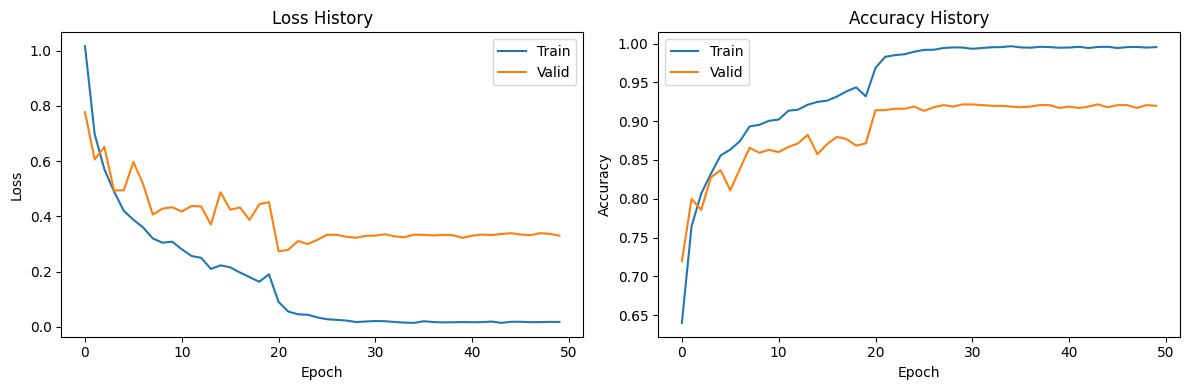

<ipython-input-20-a136646c9f14>:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Accuracy: 0.9218


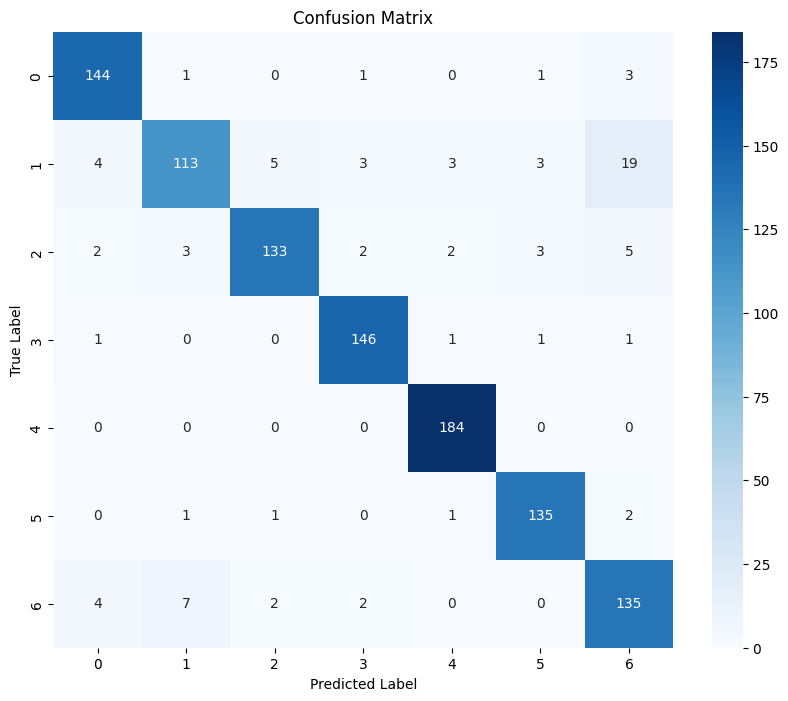


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       150
           1       0.90      0.75      0.82       150
           2       0.94      0.89      0.91       150
           3       0.95      0.97      0.96       150
           4       0.96      1.00      0.98       184
           5       0.94      0.96      0.95       140
           6       0.82      0.90      0.86       150

    accuracy                           0.92      1074
   macro avg       0.92      0.92      0.92      1074
weighted avg       0.92      0.92      0.92      1074



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

class MFCC_LSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=128, num_layers=2, num_classes=8, dropout=0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,      # 13 MFCC features
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(dropout)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )

    def attention_net(self, lstm_output):
        attn_weights = self.attention(lstm_output)
        soft_attn_weights = torch.softmax(attn_weights, 1)
        context = torch.sum(lstm_output * soft_attn_weights, 1)
        return context

    def forward(self, x):
        # x shape: (batch_size, 13, 200)
        # Transpose to (batch_size, 200, 13) for LSTM
        x = x.transpose(1, 2)

        lstm_out, _ = self.lstm(x)

        # Apply attention
        attn_out = self.attention_net(lstm_out)

        # Fully connected layers
        out = self.fc1(attn_out)
        out = self.fc2(out)
        return out

# Training function with progress bar
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc='Training')
    for batch_x, batch_y in progress_bar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{total_loss/len(progress_bar):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    return total_loss / len(train_loader), correct / total

# Validation function
def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    return total_loss / len(valid_loader), correct / total

# Prepare your data
def prepare_data_loaders(X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32):
    # Convert to tensors
    train_data = torch.FloatTensor(X_train)
    train_labels = torch.LongTensor(y_train)
    valid_data = torch.FloatTensor(X_valid)
    valid_labels = torch.LongTensor(y_valid)
    test_data = torch.FloatTensor(X_test)
    test_labels = torch.LongTensor(y_test)

    # Create datasets
    train_dataset = TensorDataset(train_data, train_labels)
    valid_dataset = TensorDataset(valid_data, valid_labels)
    test_dataset = TensorDataset(test_data, test_labels)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, valid_loader, test_loader

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Main training loop
def main():
    # Hyperparameters
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.3
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Remap labels to be consecutive
    label_map = {0:0, 2:1, 3:2, 4:3, 6:4, 8:5, 9:6}
    y_train_mapped = np.array([label_map[y] for y in y_train])
    y_valid_mapped = np.array([label_map[y] for y in y_valid])
    y_test_mapped = np.array([label_map[y] for y in y_test])

    # Prepare data loaders
    train_loader, valid_loader, test_loader = prepare_data_loaders(
        X_train, y_train_mapped,
        X_valid, y_valid_mapped,
        X_test, y_test_mapped,
        BATCH_SIZE
    )

    # Initialize model
    model = MFCC_LSTM(
        input_size=13,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        num_classes=len(label_map),
        dropout=DROPOUT
    ).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Training history
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    best_valid_acc = 0

    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

        # Store history
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

        # Learning rate scheduling
        scheduler.step(valid_loss)

        # Save best model
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), 'best_model.pth')

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Valid')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(valid_accs, label='Valid')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    print(f'\nTest Accuracy: {test_acc:.4f}')

    # Get predictions for confusion matrix
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.numpy())

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, classes=range(len(label_map)))

    # Print classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds))

if __name__ == "__main__":
    main()

In [ ]:
import torch
import librosa
import numpy as np
from torch import nn

def extract_mfcc_features(audio_path):
    """
    Extract MFCC features from an audio file.
    Returns features of shape (13, 200) through padding or truncating.
    """
    # Load audio file
    y, sr = librosa.load(audio_path)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Pad or truncate to 200 time steps
    if mfcc.shape[1] < 200:
        # Pad with zeros if shorter
        pad_width = ((0, 0), (0, 200 - mfcc.shape[1]))
        mfcc = np.pad(mfcc, pad_width, mode='constant')
    else:
        # Truncate if longer
        mfcc = mfcc[:, :200]

    return mfcc

def detect_gunshot(audio_path, model_path, device='cpu'):
    """
    Detect gunshot in audio file using the trained model.
    Returns predicted class and probability.
    """
    # Initialize model
    model = MFCC_LSTM(input_size=13, hidden_size=128, num_layers=2, num_classes=7)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Extract features
    features = extract_mfcc_features(audio_path)

    # Convert to tensor and add batch dimension
    features_tensor = torch.FloatTensor(features).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    # Map back to original labels (assuming the same mapping as in training)
    label_map = {0:0, 1:2, 2:3, 3:4, 4:6, 5:8, 6:9}
    original_label = label_map[predicted_class]

    return original_label, confidence

def process_audio_file(audio_path, model_path):
    """
    Process an audio file and print the detection results.
    """
    # Detect gunshot
    predicted_class, confidence = detect_gunshot(audio_path, model_path)

    # Print results
    print(f"Audio file: {audio_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

audio_file = '/content/Dog Barking Sound Effect - Copyright free [TubeRipper.com].wav'
model_path = "/content/best_model.pth"
process_audio_file(audio_file, model_path)

<ipython-input-24-41f937b72371>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Audio file: /content/Dog Barking Sound Effect - Copyright free [TubeRipper.com].wav
Predicted class: 3
Confidence: 100.00%


In [ ]:
# # code for early stopping - experimental

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import numpy as np
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import seaborn as sns
# import copy

# class EarlyStopping:
#     """Early stopping to prevent overfitting"""
#     def __init__(self, patience=7, min_delta=0, verbose=False):
#         """
#         Args:
#             patience (int): How many epochs to wait before stopping when loss is
#                           not improving
#             min_delta (float): Minimum change in the monitored quantity to qualify
#                              as an improvement
#             verbose (bool): If True, prints a message for each validation loss
#                           improvement
#         """
#         self.patience = patience
#         self.min_delta = min_delta
#         self.verbose = verbose
#         self.counter = 0
#         self.best_loss = None
#         self.best_acc = None
#         self.best_model = None
#         self.early_stop = False

#     def __call__(self, val_loss, val_acc, model):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#             self.best_acc = val_acc
#             self.best_model = copy.deepcopy(model.state_dict())
#         elif val_loss > self.best_loss + self.min_delta:
#             self.counter += 1
#             if self.verbose:
#                 print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             if val_loss < self.best_loss:
#                 if self.verbose:
#                     print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f})')
#                 self.best_loss = val_loss
#             if val_acc > self.best_acc:
#                 if self.verbose:
#                     print(f'Validation accuracy improved ({self.best_acc:.6f} --> {val_acc:.6f})')
#                 self.best_acc = val_acc
#                 self.best_model = copy.deepcopy(model.state_dict())
#             self.counter = 0

# def main():
#     # Hyperparameters
#     HIDDEN_SIZE = 128
#     NUM_LAYERS = 2
#     DROPOUT = 0.3
#     BATCH_SIZE = 32
#     NUM_EPOCHS = 50
#     LEARNING_RATE = 0.001
#     PATIENCE = 10  # Early stopping patience
#     MIN_DELTA = 1e-4  # Minimum change in validation loss to qualify as improvement

#     # Set device
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     # Remap labels to be consecutive
#     label_map = {0:0, 2:1, 3:2, 4:3, 6:4, 8:5, 9:6}
#     y_train_mapped = np.array([label_map[y] for y in y_train])
#     y_valid_mapped = np.array([label_map[y] for y in y_valid])
#     y_test_mapped = np.array([label_map[y] for y in y_test])

#     # Prepare data loaders
#     train_loader, valid_loader, test_loader = prepare_data_loaders(
#         X_train, y_train_mapped,
#         X_valid, y_valid_mapped,
#         X_test, y_test_mapped,
#         BATCH_SIZE
#     )

#     # Initialize model
#     model = MFCC_LSTM(
#         input_size=13,
#         hidden_size=HIDDEN_SIZE,
#         num_layers=NUM_LAYERS,
#         num_classes=len(label_map),
#         dropout=DROPOUT
#     ).to(device)

#     # Loss and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer,
#         mode='min',
#         factor=0.1,
#         patience=5,
#         min_lr=1e-6
#     )

#     # Initialize early stopping
#     early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, verbose=True)

#     # Training history
#     train_losses = []
#     valid_losses = []
#     train_accs = []
#     valid_accs = []

#     # Training loop
#     for epoch in range(NUM_EPOCHS):
#         print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')

#         # Train
#         train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

#         # Validate
#         valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

#         # Store history
#         train_losses.append(train_loss)
#         valid_losses.append(valid_loss)
#         train_accs.append(train_acc)
#         valid_accs.append(valid_acc)

#         # Print epoch results
#         print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
#         print(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

#         # Early stopping check
#         early_stopping(valid_loss, valid_acc, model)

#         # Learning rate scheduling
#         scheduler.step(valid_loss)

#         if early_stopping.early_stop:
#             print("Early stopping triggered")
#             break

#     # Load best model
#     model.load_state_dict(early_stopping.best_model)
#     torch.save(model.state_dict(), 'best_model.pth')
#     print(f'Best validation accuracy: {early_stopping.best_acc:.4f}')

#     # Plot training history
#     plt.figure(figsize=(12, 4))

#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Train')
#     plt.plot(valid_losses, label='Valid')
#     plt.title('Loss History')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(train_accs, label='Train')
#     plt.plot(valid_accs, label='Valid')
#     plt.title('Accuracy History')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

#     # Evaluate on test set
#     test_loss, test_acc = validate(model, test_loader, criterion, device)
#     print(f'\nTest Accuracy: {test_acc:.4f}')

#     # Get predictions for confusion matrix
#     all_preds = []
#     all_labels = []
#     model.eval()
#     with torch.no_grad():
#         for batch_x, batch_y in test_loader:
#             batch_x = batch_x.to(device)
#             outputs = model(batch_x)
#             _, predicted = torch.max(outputs.data, 1)
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(batch_y.numpy())

#     # Plot confusion matrix
#     plot_confusion_matrix(all_labels, all_preds, classes=range(len(label_map)))

#     # Print classification report
#     print('\nClassification Report:')
#     print(classification_report(all_labels, all_preds))

# if __name__ == "__main__":
#     main()